<h1>Hackathon Challenge ITADATA 2024 -  Team UnisaDataBusters - Task 1</h1>

<h2> Data Exploration and Preprocessing </h2>

<h3> EDA (Exploratory Data Analysis) </h3>

Fase preparatoria, caricamento dataset e visualizzazione info generali

In [8]:
!pip install statsmodels
!pip install imblearn
!pip install matplotlib
!pip install seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import joblib

train_df = pd.read_csv('./data/training.csv')
print(train_df.info())
train_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056160 entries, 0 to 2056159
Data columns (total 44 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   client_id                     int64  
 1   product8                      int64  
 2   product10                     int64  
 3   product13                     int64  
 4   product12                     int64  
 5   product11                     int64  
 6   product4                      int64  
 7   product17                     int64  
 8   product2                      int64  
 9   product3                      int64  
 10  product1                      int64  
 11  product7                      int64  
 12  product6                      int64  
 13  product5                      int64  
 14  product14                     int64  
 15  product15                     int64  
 16  product16                     int64  
 17  product9                      int64  
 18  has_products          

,client_id,product8,product10,product13,product12,product11,product4,product17,product2,product3,...,counter_num_inbound,counter_num_outbound,securities_operations,securities_bought,securities_sold,counter_amt_tot,counter_num_tot,period,category,repays_debt
0,0,1,0,0,0,1,0,0,1,1,...,45,61,0,0,0,192148.965822,106,1,2,0
1,0,1,1,1,1,0,0,0,1,1,...,31,50,0,0,0,-56342.014232,81,2,2,0
2,0,1,0,1,0,0,1,0,0,1,...,16,47,0,0,0,-159247.483476,63,3,2,0
3,0,1,1,1,0,1,1,1,0,1,...,24,53,0,0,0,12234.918920,77,4,2,0
4,0,1,0,1,1,1,0,0,0,1,...,24,53,0,0,0,-104456.783924,77,5,2,0


Controllo valori unici e nulli. <br>
Da qui abbiamo sia notato la mancanza di variabili oggetto, sia la mancanza di valori nulli/duplicati nelle varie colonne.

In [9]:
train_df.describe()
train_df.nunique()

missing_values = train_df.isnull().sum()
train_df.duplicated().value_counts()
train_df.isnull().sum().reset_index

<bound method Series.reset_index of client_id                       0
product8                        0
product10                       0
product13                       0
product12                       0
product11                       0
product4                        0
product17                       0
product2                        0
product3                        0
product1                        0
product7                        0
product6                        0
product5                        0
product14                       0
product15                       0
product16                       0
product9                        0
has_products                    0
balance                         0
left_bank                       0
joined_bank                     0
wire_transfers2_amt_inbound     0
wire_transfers1_amt_inbound     0
wire_transfers2_amt_outbound    0
wire_transfers1_amt_outbound    0
counter_amt_inbound             0
counter_amt_outbound            0
securities_b

Analisi della distribuzione dei valori nelle singole feature; essendo tutte numeriche (int, float), possiamo eseguire la visualizzazione grafica su tutte le features

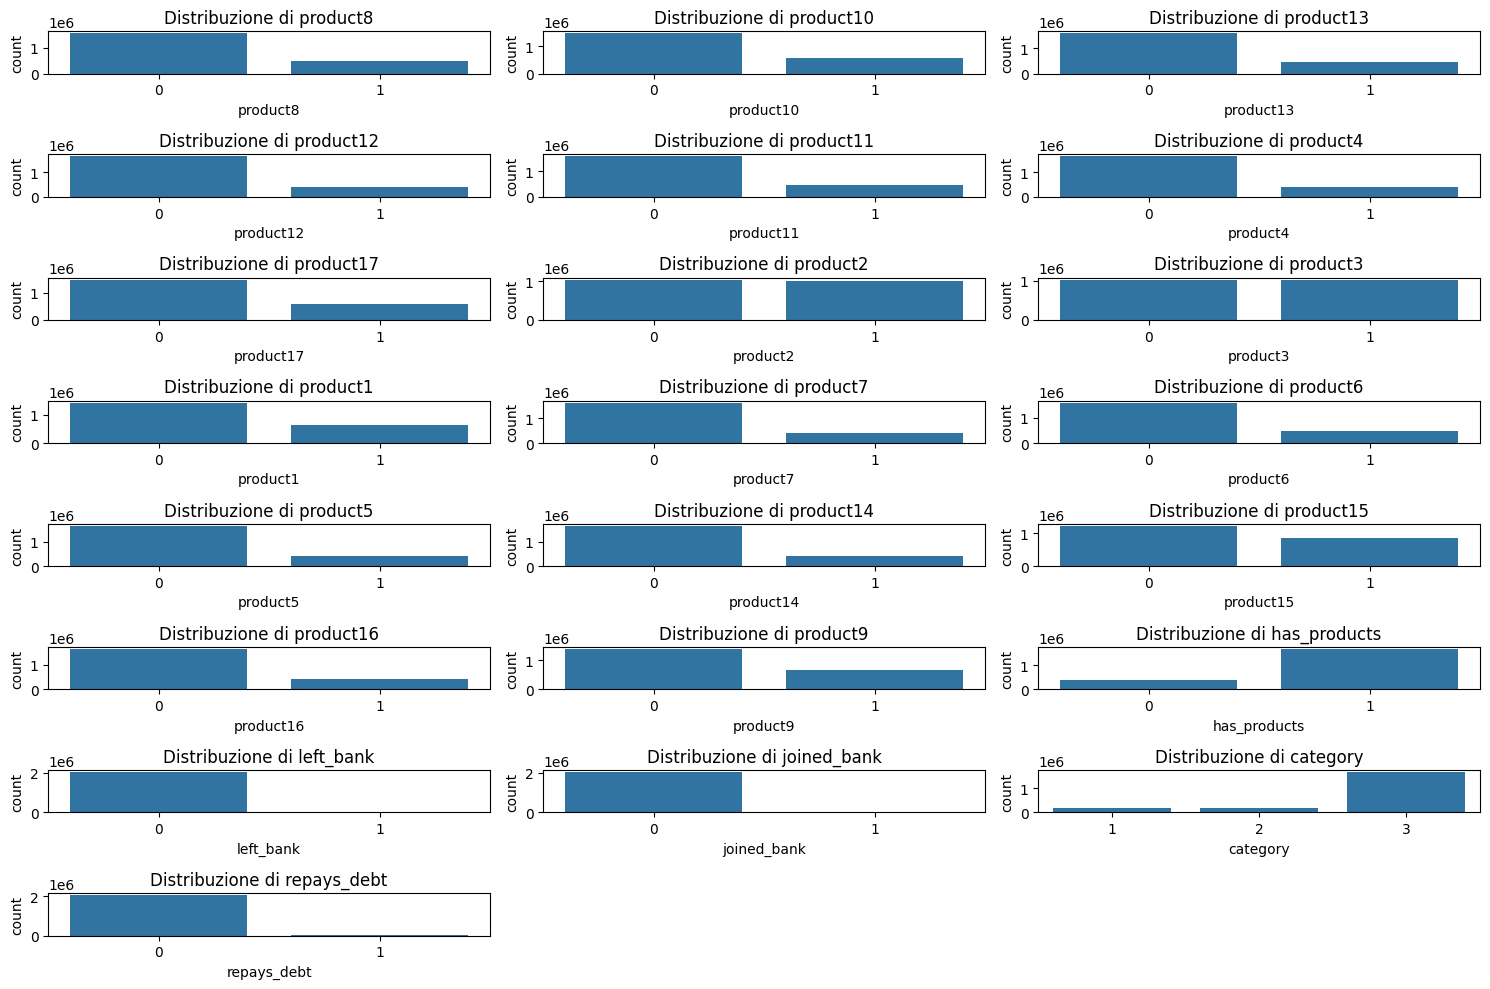

In [10]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
limited_unique_cols = [col for col in numerical_columns if train_df[col].nunique() < 20]

plt.figure(figsize=(15, 10))

for i, col in enumerate(limited_unique_cols, 1):
    plt.subplot(len(limited_unique_cols) // 3 + 1, 3, i)
    sns.countplot(x=col, data=train_df)
    plt.title(f'Distribuzione di {col}')
    plt.tight_layout()

plt.show()


Visualizzazione correlazione delle feature rispetto alla variabile target, prima mediante stampa di valori e ooi mediante visualizzazione grafica.

In [11]:
correlation_matrix = train_df.corr()

print(correlation_matrix["repays_debt"].sort_values(ascending=False))

repays_debt                     1.000000
left_bank                       0.028332
client_id                       0.014273
product9                        0.009799
product13                       0.004791
product1                        0.003403
product7                        0.003176
wire_transfers2_amt_outbound    0.002716
wire_transfers1_amt_outbound    0.002290
counter_amt_outbound            0.002007
product4                        0.001557
product14                       0.001047
product12                       0.000580
securities_sold_amt            -0.000129
securities_bought_amt          -0.000130
counter_amt_tot                -0.000516
product16                      -0.000642
wire_transfers2_amt_inbound    -0.000949
securities_sold                -0.001008
product5                       -0.001071
securities_operations          -0.001132
securities_bought              -0.001178
wire_transfers1_num_inbound    -0.001833
counter_amt_inbound            -0.002284
product11       

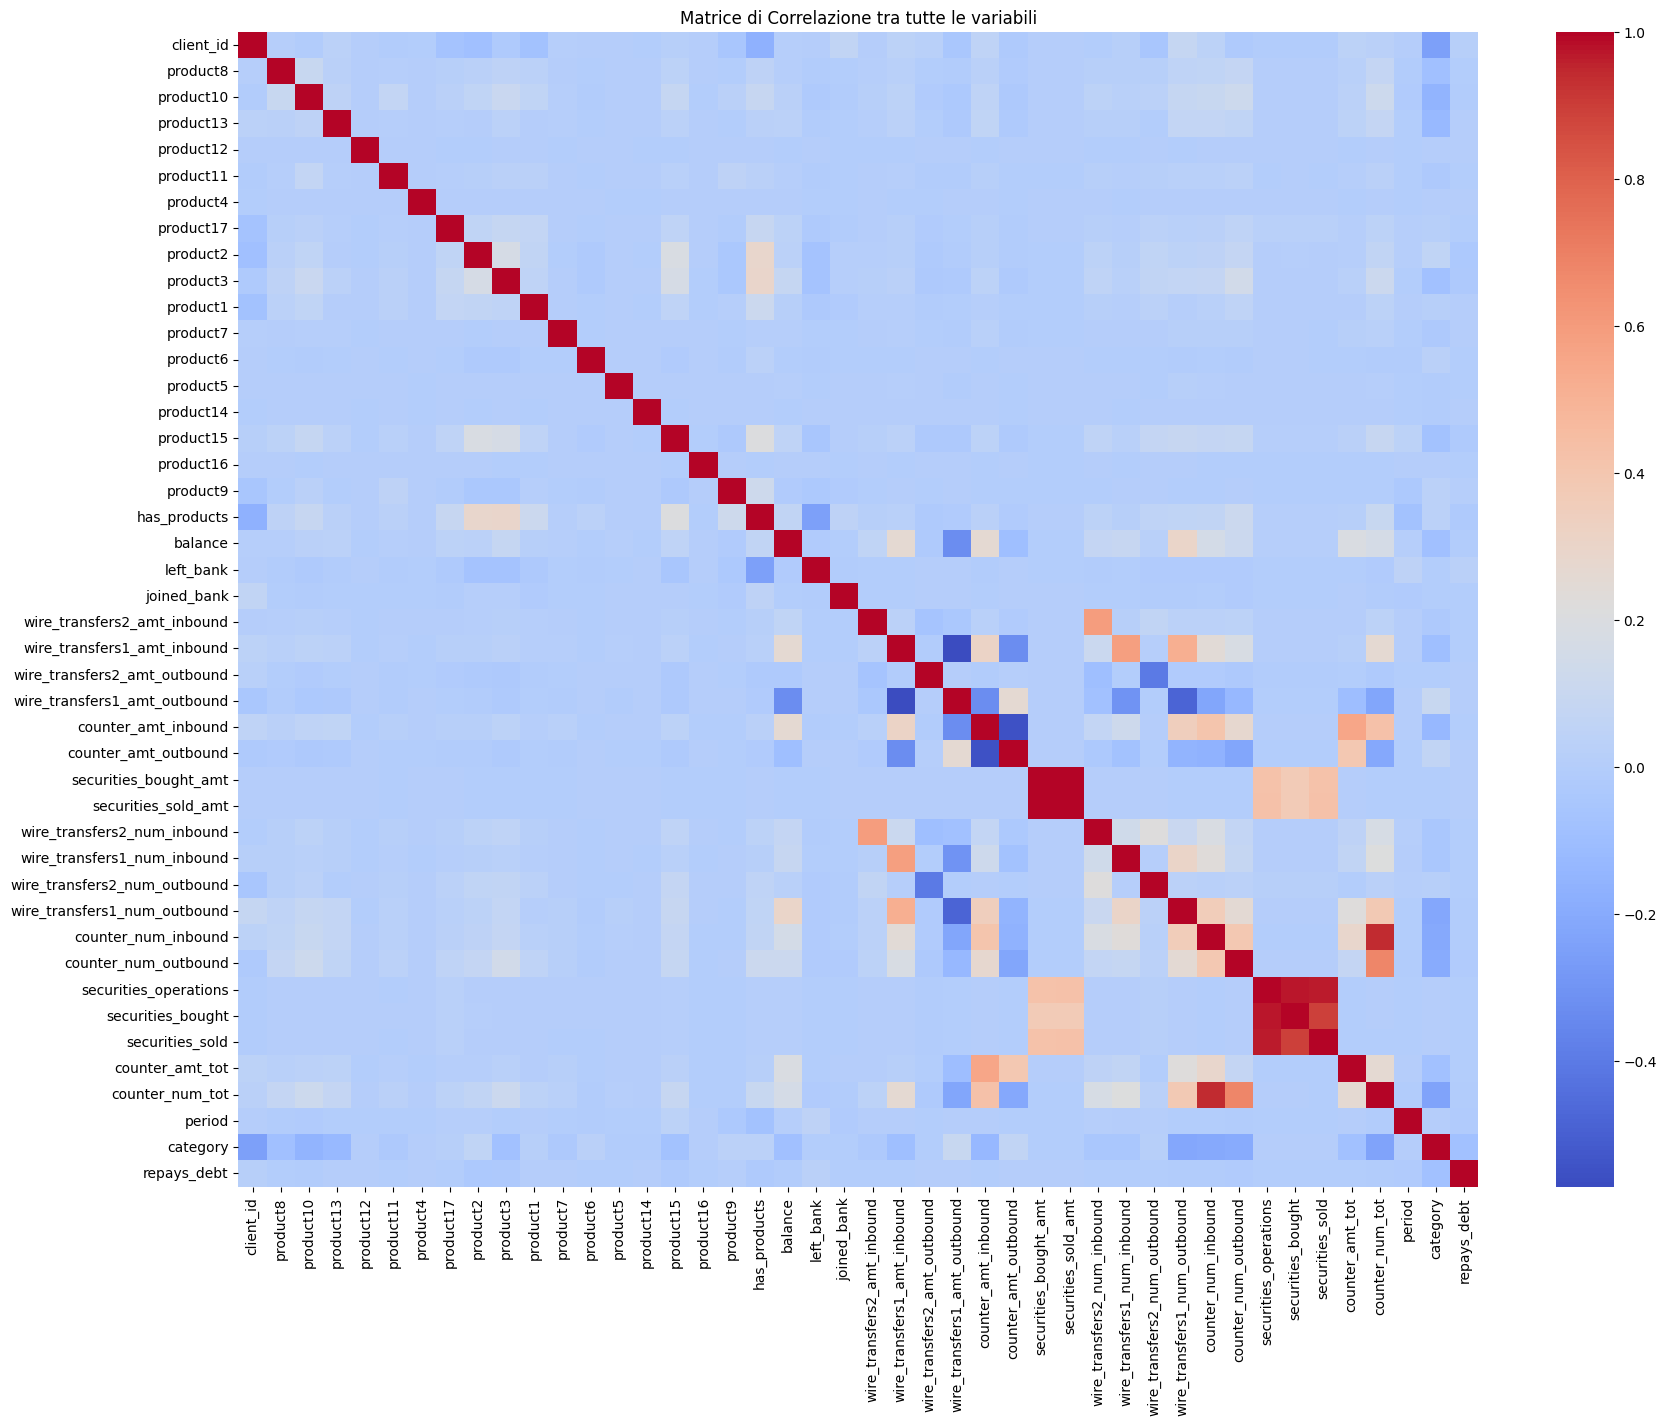

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix = train_df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione tra tutte le variabili')
plt.show()

Per avere un'idea della distribuzione dei vari valori relativi ad un singolo cliente, abbiamo effettuato una stampa di grafici relativi alle varie features: andamento del saldo nei vari periodi, trend, autocorrelazioni

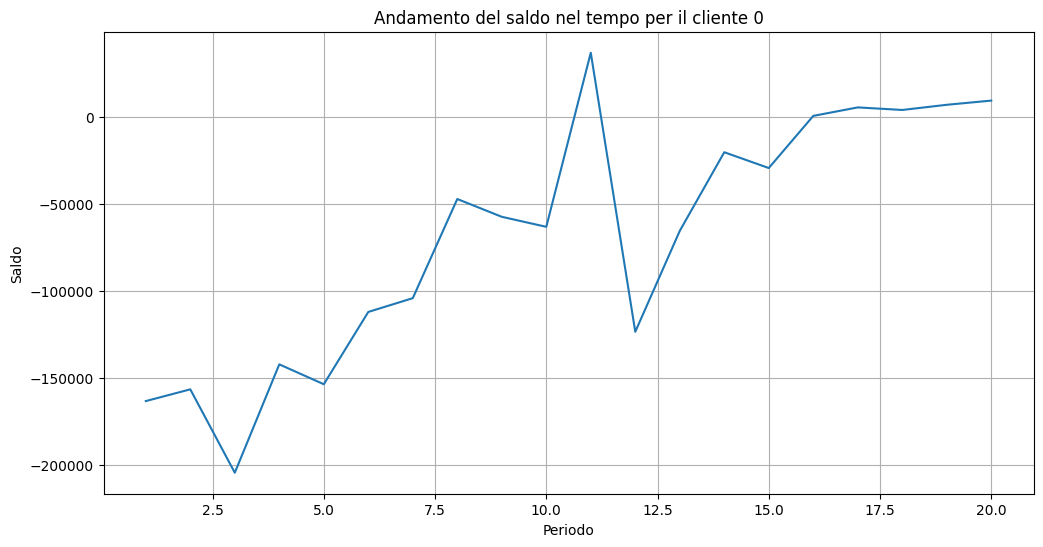

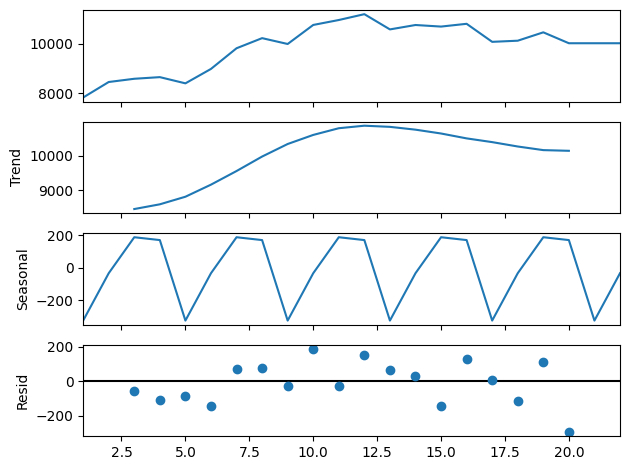

<Figure size 1200x600 with 0 Axes>

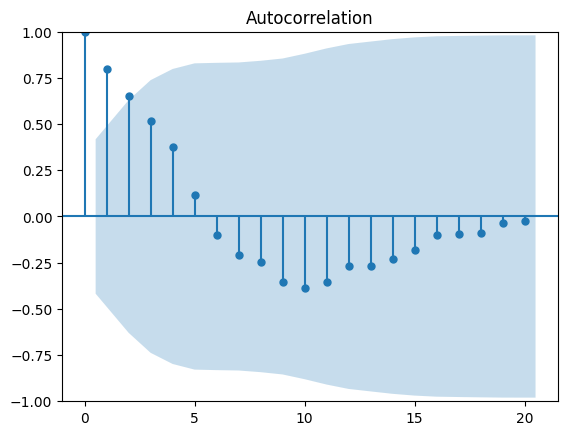

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Pivot dei dati: creare una tabella con periodi come colonne e client_id come indice
pivot_df = train_df.pivot_table(index='client_id', columns='period', values='balance', aggfunc='mean')
pivot_df = pivot_df.reindex(columns=range(1, 23), fill_value=np.nan)

# Esempio visualizzazione per un cliente
client_id_example = pivot_df.index[0]  
plt.figure(figsize=(12, 6))
plt.plot(pivot_df.columns, pivot_df.loc[client_id_example])
plt.title(f'Andamento del saldo nel tempo per il cliente {client_id_example}')
plt.xlabel('Periodo')
plt.ylabel('Saldo')
plt.grid(True)
plt.show()

# Analisi trand e stagionalità
mean_series = pivot_df.mean(axis=0)  
mean_series = mean_series.interpolate()  
result = seasonal_decompose(mean_series, model='additive', period=4)  
result.plot()
plt.show()

# Autocorrelazione e autocorrelazione parziale
plt.figure(figsize=(12, 6))
plot_acf(mean_series.dropna(), lags=20)
plt.show()


Stampa della distribuzione del bilancio basandoci su periodo e categoria

/tmp/ipykernel_2570/3028350110.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='period', y='balance', hue='category', style='repays_debt', data=train_df, marker='o', ci='sd')


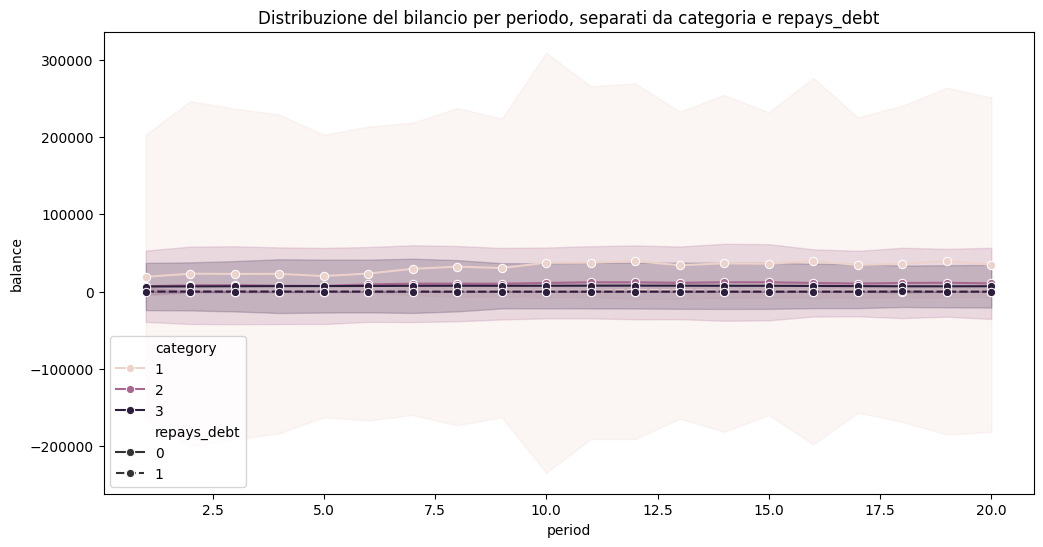

/tmp/ipykernel_2570/3028350110.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='period', y='counts', hue='category', data=df_grouped, ci=None)
/tmp/ipykernel_2570/3028350110.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='period', y='counts', hue='repays_debt', data=df_grouped, marker='o', ci=None, palette='dark')


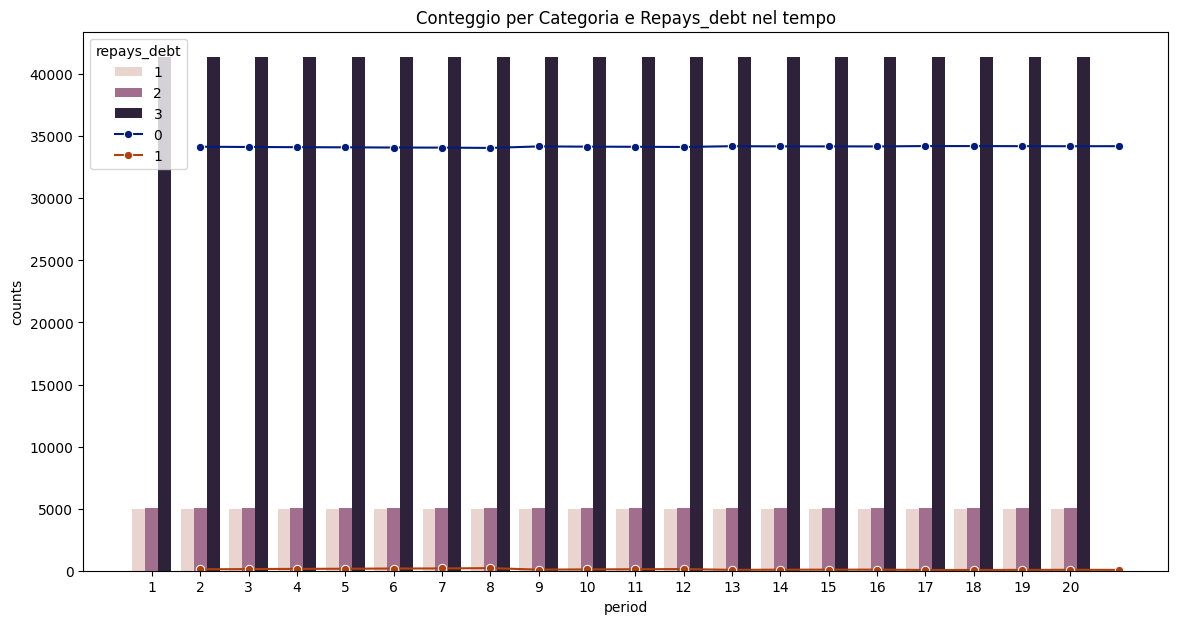

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='period', y='balance', hue='category', style='repays_debt', data=train_df, marker='o', ci='sd')
plt.title('Distribuzione del bilancio per periodo, separati da categoria e repays_debt')
plt.show()

df_grouped = train_df.groupby(['period', 'category', 'repays_debt']).size().reset_index(name='counts')

plt.figure(figsize=(14, 7))

sns.barplot(x='period', y='counts', hue='category', data=df_grouped, ci=None)
sns.lineplot(x='period', y='counts', hue='repays_debt', data=df_grouped, marker='o', ci=None, palette='dark')

plt.title('Conteggio per Categoria e Repays_debt nel tempo')
plt.show()

Stampa di vari grafici che dimostrano la distribuzione di alcune features sulla base di altre

/tmp/ipykernel_2570/3326728864.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='period', y='balance', hue='repays_debt', data=train_df, marker='o', ci='sd')


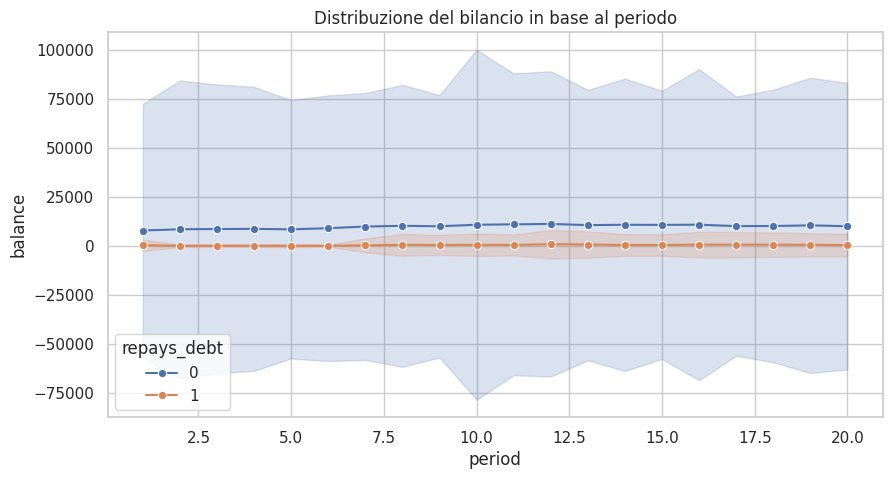

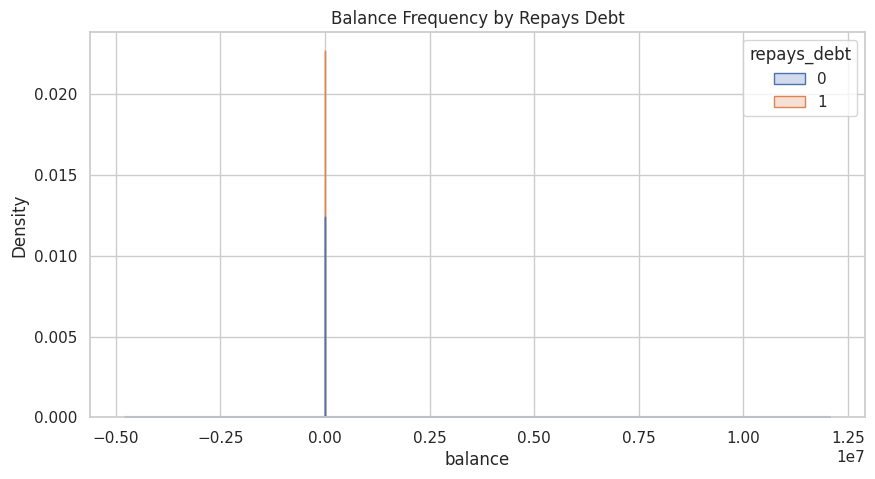

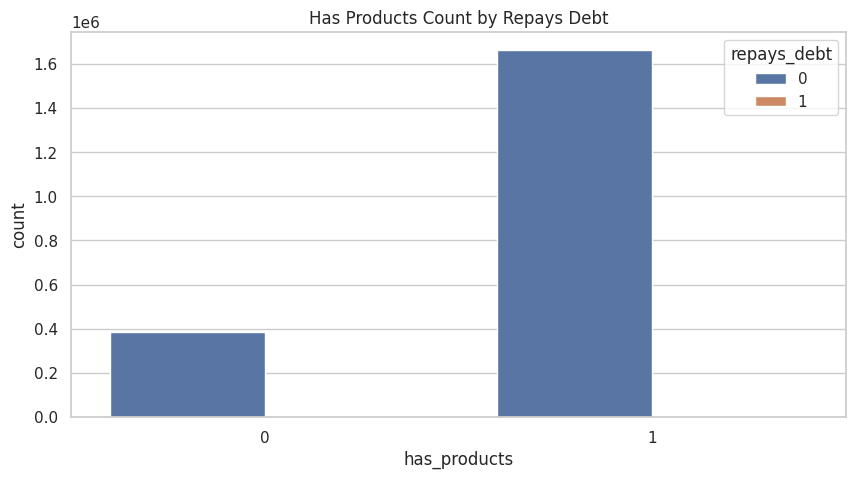

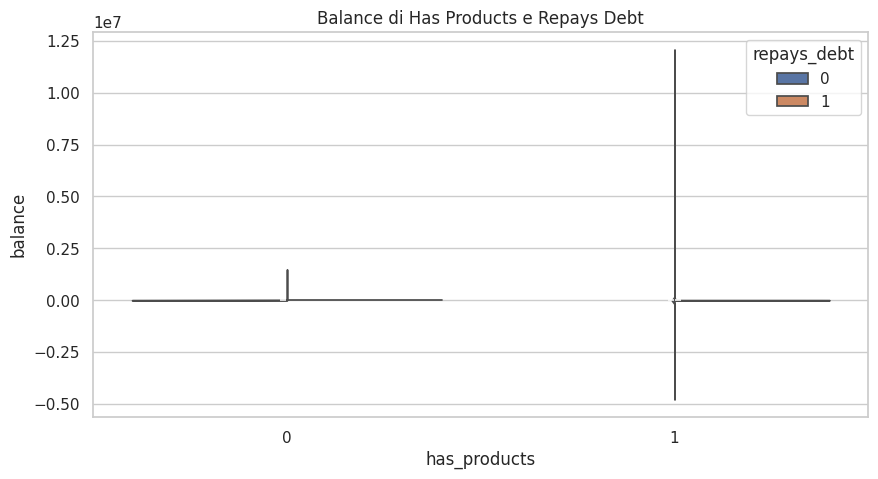

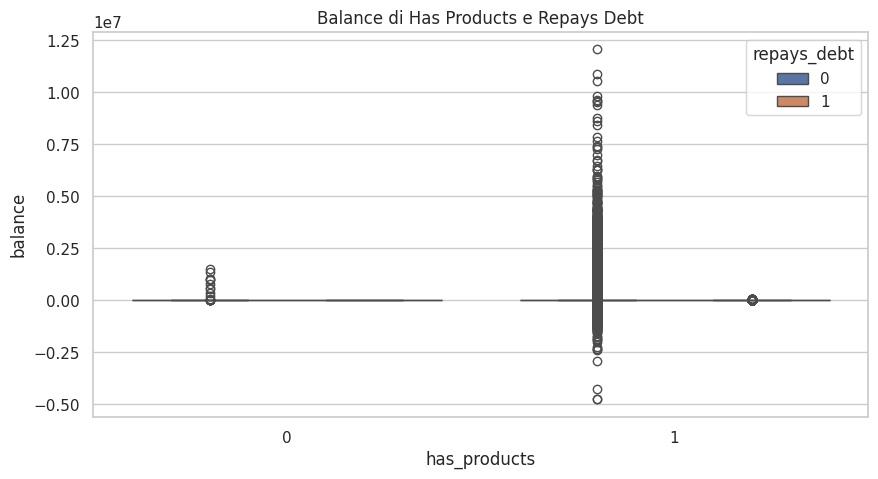

/tmp/ipykernel_2570/3326728864.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='repays_debt', y=feature, data=train_df, palette="Set3")
/tmp/ipykernel_2570/3326728864.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='repays_debt', y=feature, data=train_df, palette="Set2")


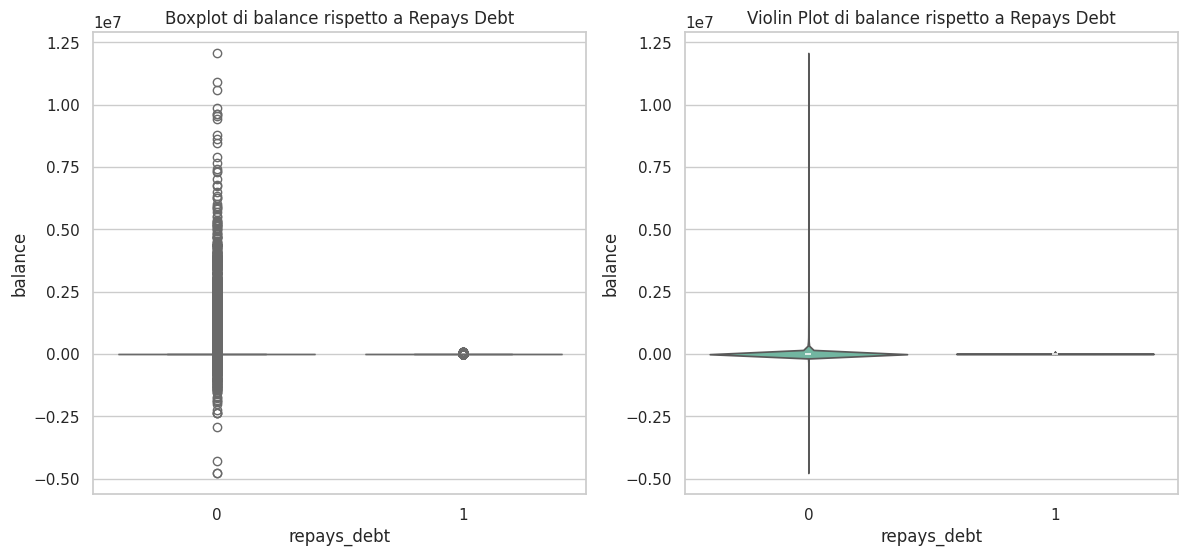

/tmp/ipykernel_2570/3326728864.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='repays_debt', y=feature, data=train_df, palette="Set3")
/tmp/ipykernel_2570/3326728864.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='repays_debt', y=feature, data=train_df, palette="Set2")


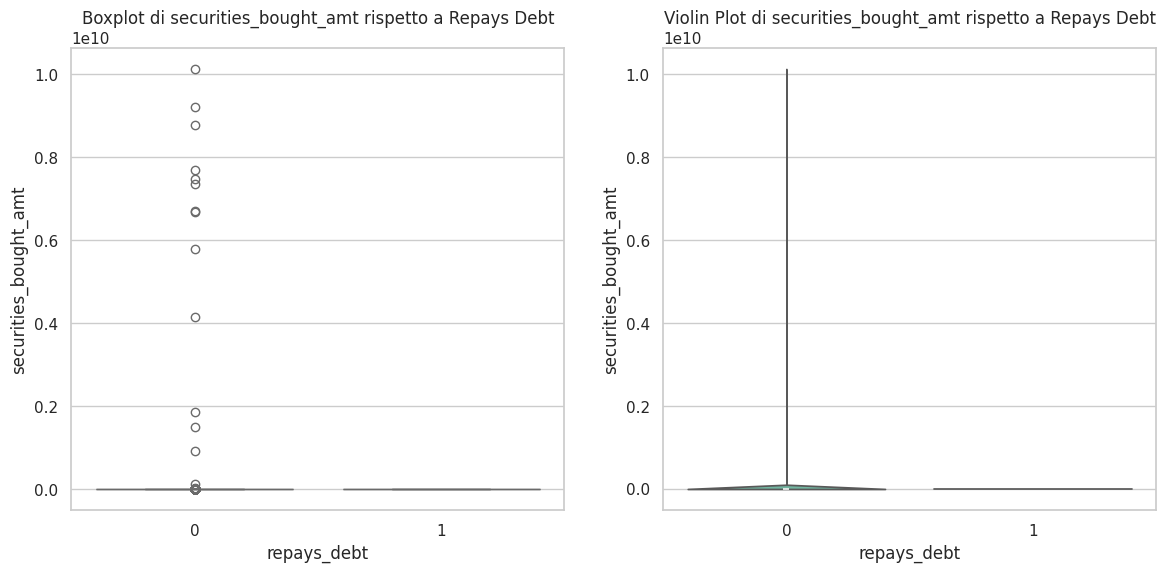

/tmp/ipykernel_2570/3326728864.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='repays_debt', y=feature, data=train_df, palette="Set3")
/tmp/ipykernel_2570/3326728864.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='repays_debt', y=feature, data=train_df, palette="Set2")


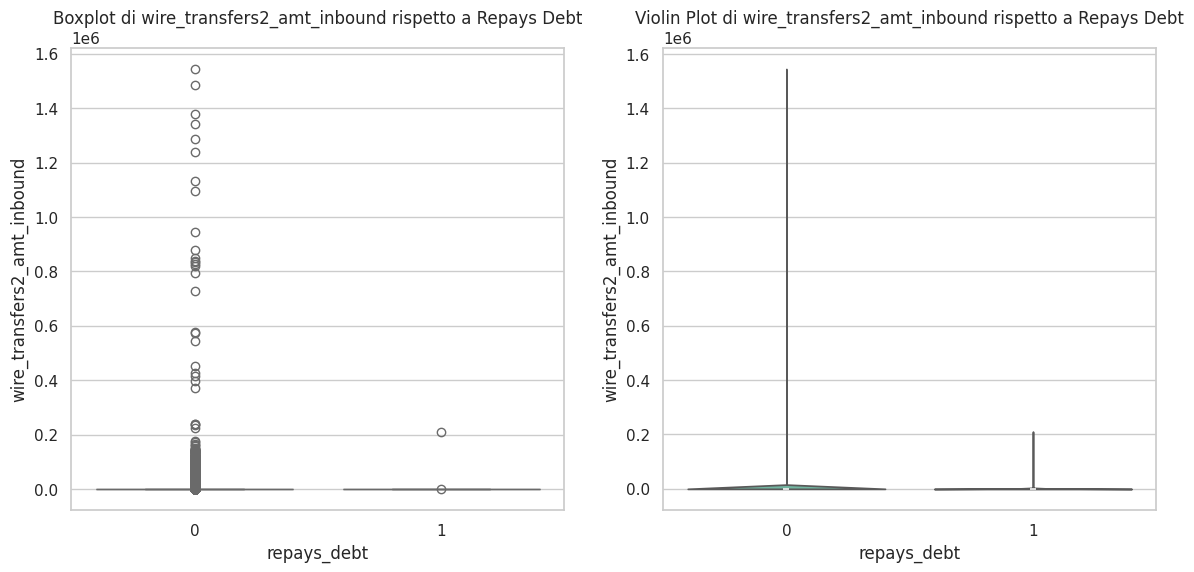

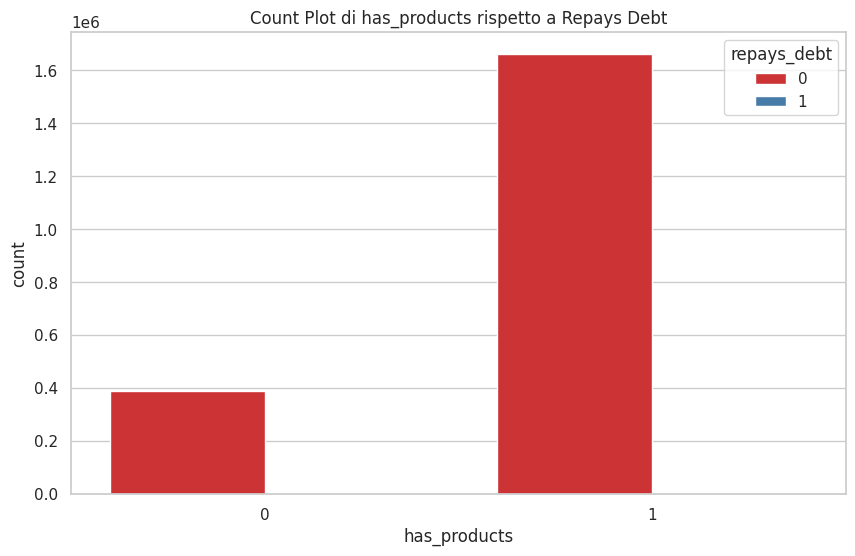

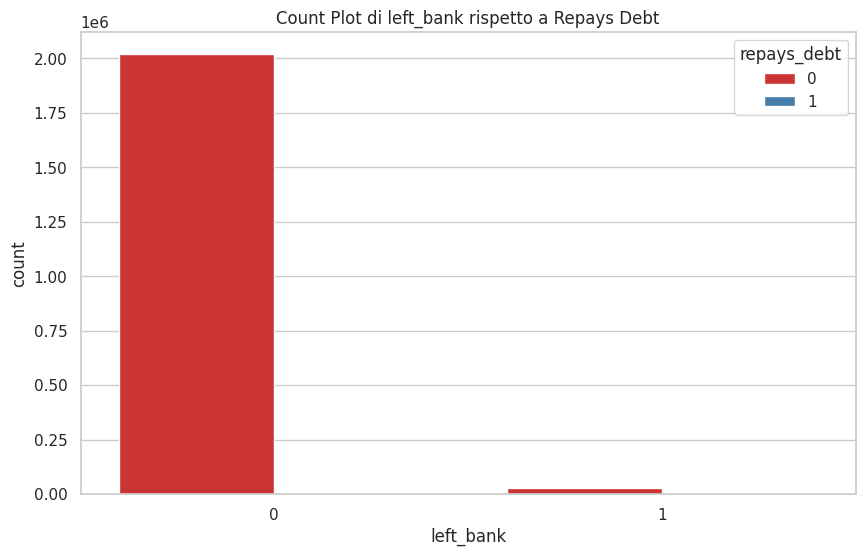

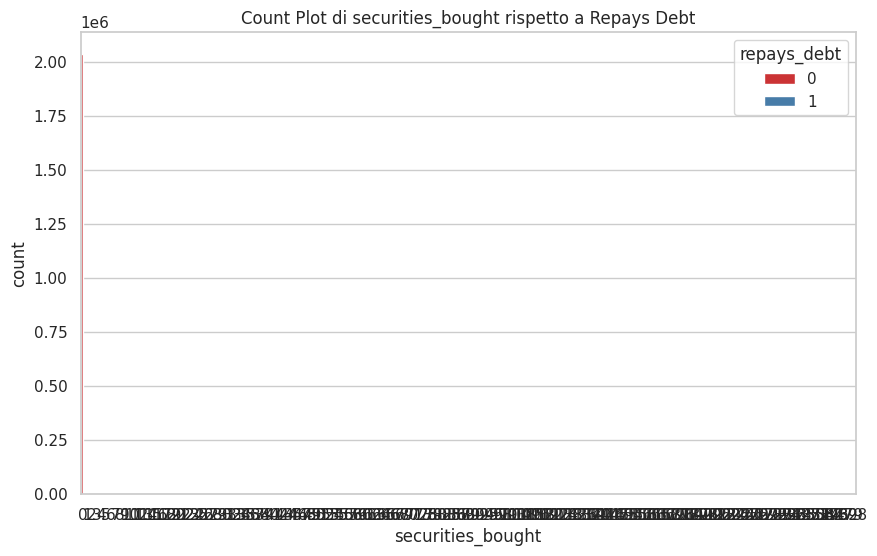

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Lineplot per Balance vs Period, separato per repays_debt
plt.figure(figsize=(10, 5))
sns.lineplot(x='period', y='balance', hue='repays_debt', data=train_df, marker='o', ci='sd')
plt.title('Distribuzione del bilancio in base al periodo')
plt.show()

# Distribuzione di Balance per repays_debt con kde
plt.figure(figsize=(10, 5))
sns.histplot(train_df, x='balance', hue='repays_debt', kde=True, element='step', stat='density', common_norm=False)
plt.title('Balance Frequency by Repays Debt')
plt.show()

# Countplot per Has Products rispetto a repays_debt
plt.figure(figsize=(10, 5))
sns.countplot(x='has_products', hue='repays_debt', data=train_df)
plt.title('Has Products Count by Repays Debt')
plt.show()

# Violinplot per Balance rispetto a Has Products e repays_debt
plt.figure(figsize=(10, 5))
sns.violinplot(x='has_products', y='balance', hue='repays_debt', data=train_df, split=True)
plt.title('Balance di Has Products e Repays Debt')
plt.show()

# Boxplot per Balance rispetto a Has Products e repays_debt
plt.figure(figsize=(10, 5))
sns.boxplot(x='has_products', y='balance', hue='repays_debt', data=train_df)
plt.title('Balance di Has Products e Repays Debt')
plt.show()

# Boxplot e Violinplot per variabili numeriche rispetto a repays_debt
numerical_features = ['balance', 'securities_bought_amt', 'wire_transfers2_amt_inbound']
for feature in numerical_features:
    plt.figure(figsize=(14, 6))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='repays_debt', y=feature, data=train_df, palette="Set3")
    plt.title(f"Boxplot di {feature} rispetto a Repays Debt")

    # Violin Plot
    plt.subplot(1, 2, 2)
    sns.violinplot(x='repays_debt', y=feature, data=train_df, palette="Set2")
    plt.title(f"Violin Plot di {feature} rispetto a Repays Debt")

    plt.show()

# Countplot per variabili categoriche rispetto a repays_debt
categorical_features = ['has_products', 'left_bank', 'securities_bought']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='repays_debt', data=train_df, palette="Set1")
    plt.title(f"Count Plot di {feature} rispetto a Repays Debt")
    plt.show()


I boxplot e i violinplot sono strumenti grafici che visualizzano la distribuzione delle variabili numeriche: i boxplot mostrano la mediana, i quartili e gli outlier, mentre i violinplot combinano queste informazioni con la stima della densità, evidenziando la forma della distribuzione. Questi grafici sono utili per analizzare la variabilità, identificare outlier e confrontare distribuzioni tra categorie o gruppi.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns

n_cols = len(numerical_columns)

plt.figure(figsize=(15, n_cols * 5))

for i, col in enumerate(numerical_columns):
    plt.subplot(n_cols, 2, 2*i+1)
    sns.boxplot(x='repays_debt', y=col, data=train_df)
    plt.title(f'Boxplot di {col}')

    plt.subplot(n_cols, 2, 2*i+2)
    sns.violinplot(x='repays_debt', y=col, data=train_df)
    plt.title(f'Violinplot di {col}')

plt.tight_layout()
plt.show()

L'analisi dell'autocorrelazione e dell'autocorrelazione parziale ha rivelato che i lag più significativi erano quelli di 1, 2 e 3 periodi, con un'influenza predominante dei primi due. Tuttavia, durante l'ottimizzazione finale del modello, si è deciso di utilizzare finestre temporali e lag di 1, 3 e 5 periodi per catturare meglio le dinamiche a breve e medio termine, migliorando così le prestazioni predittive.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

train_df = train_df.sort_values(['client_id', 'period'])

for client_id in train_df['client_id'].unique():
    series = train_df[train_df['client_id'] == client_id]['repays_debt']
    if series.nunique() > 1:
        print(f"Client ID {client_id} ha una variabilità sufficiente, procedo con i grafici.")
        
        # Grafico di Autocorrelazione (ACF)
        plt.figure(figsize=(12, 6))
        plot_acf(series, lags=9) 
        plt.title(f'Autocorrelation for Client ID {client_id}')
        plt.show()

        # Grafico di Correlazione Parziale (PACF)
        plt.figure(figsize=(12, 6))
        plot_pacf(series, lags=9)
        plt.title(f'Partial Autocorrelation for Client ID {client_id}')
        plt.show()

<h3>Data cleaning</h3>

Durante il data cleaning, abbiamo identificato pochi outlier e deciso di mantenerli, poiché non influivano negativamente sulle prestazioni. Le distribuzioni delle variabili sono state verificate e, dove necessario, abbiamo applicato trasformazioni logaritmiche o standard scaling, salvo poi optare per l'uso di dati non scalati dopo aver valutato le prestazioni del modello. Inoltre, per bilanciare la variabile dipendente, abbiamo applicato tecniche di undersampling e oversampling.

<h3>Feature engineering</h3>

Le feature elencate di seguito sono quelle effettivamente selezionate per il modello finale. Queste rappresentano le variabili più rilevanti identificate attraverso un'analisi approfondita delle prestazioni del modello, si noti che sono state creato e testate molte altre feature:

- category:
Questa feature rappresenta la categoria del cliente. Ed è la feature più correlata allla variabile dipendente. Ed è quella più importante per il modello.

- is_high_balance_client:
Feature binaria che indica se il cliente ha un saldo (balance) superiore alla mediana del dataset. Risulta essere la seconda feature più correlata alla variabile dipendente. Un cliente con un saldo elevato potrebbe essere visto come meno rischioso, dato che ha più risorse disponibili per coprire i debiti.

- balance:
Il saldo corrente del cliente. Questa è una variabile fondamentale che indica la quantità di denaro disponibile nel conto del cliente, influenzando direttamente la sua capacità di ripagare i debiti.

- net_wire_transfers:
Questa feature rappresenta il flusso netto di denaro trasferito tramite bonifici (somma delle transazioni in entrata meno quelle in uscita). Un saldo netto positivo può indicare una buona salute finanziaria e una maggiore probabilità di ripagare i debiti.

- balance_lag_1:
Il saldo del cliente nel periodo precedente (lag di 1 periodo). Questa feature cattura la dinamica temporale del saldo del cliente, fornendo al modello un contesto su come il saldo sta cambiando nel tempo.

- net_wire_transfers_lag_1:
Il flusso netto di bonifici nel periodo precedente (lag di 1 periodo). Similmente a balance_lag_1, questa feature fornisce al modello informazioni sull'andamento delle transazioni nel tempo, aiutando a prevedere comportamenti futuri.

- balance_rolling_mean_3:
La media mobile del saldo (balance) su una finestra di 3 periodi. Simile a balance_rolling_mean_5, ma cattura trend di breve termine, fornendo informazioni più recenti sul comportamento finanziario del cliente.

- net_wire_transfers_rolling_var_3:
La varianza mobile dei bonifici netti (net_wire_transfers) su una finestra di 3 periodi. Questa feature misura la dispersione delle transazioni su un breve termine.

- balance_rolling_mean_5:
La media mobile del saldo (balance) su una finestra di 5 periodi (finestra più ampia). Questa feature aiuta a smussare le fluttuazioni nel saldo, captando eventuali trend di medio termine nel comportamento finanziario del cliente.

- net_wire_transfers_rolling_std_5:
La deviazione standard mobile dei bonifici netti (net_wire_transfers) su una finestra di 5 periodi. Questa feature misura la volatilità delle transazioni del cliente.

- period:
Il numero di periodi trascorsi. Questa feature indica la posizione temporale all'interno della serie storica dellla transazione del cliente.

- total_products:
Il numero totale di prodotti finanziari posseduti dal cliente. Per evitare di dover aggiungere troppa dimensionalità al modello selezionando ogni prodotto è stata sintetizzata tale informazione in questa feature.

- category_wire_interaction:
Feature di interazione tra la category del cliente e il valore di net_wire_transfers. Questa feature cattura l'effetto combinato tra la categoria del cliente e il flusso di bonifici, identificando potenziali variazioni nel comportamento delle transazioni in base al tipo di cliente.

In [ ]:
train_df['total_wire_transfers_inbound'] = train_df['wire_transfers1_amt_inbound'] + train_df['wire_transfers2_amt_inbound']
train_df['total_wire_transfers_outbound'] = train_df['wire_transfers1_amt_outbound'] + train_df['wire_transfers2_amt_outbound']
train_df['net_wire_transfers'] = train_df['total_wire_transfers_inbound'] - train_df['total_wire_transfers_outbound']

train_df['balance_lag_1'] = train_df.groupby('client_id')['balance'].shift(1)
train_df['net_wire_transfers_lag_1'] = train_df.groupby('client_id')['net_wire_transfers'].shift(1)

train_df['balance_rolling_mean_5'] = train_df.groupby('client_id')['balance'].rolling(window=5).mean().reset_index(level=0, drop=True)
train_df['net_wire_transfers_rolling_std_5'] = train_df.groupby('client_id')['net_wire_transfers'].rolling(window=5).std().reset_index(level=0, drop=True)

train_df['balance_rolling_mean_3'] = train_df.groupby('client_id')['balance'].rolling(window=3).mean().reset_index(level=0, drop=True).ffill().fillna(0)
train_df['net_wire_transfers_rolling_var_3'] = train_df.groupby('client_id')['net_wire_transfers'].rolling(window=3).var().reset_index(level=0, drop=True).ffill().fillna(0)

train_df['balance_rolling_mean_2'] = train_df.groupby('client_id')['balance'].rolling(window=2).mean().reset_index(level=0, drop=True).ffill().fillna(0)
train_df['net_wire_transfers_rolling_var_2'] = train_df.groupby('client_id')['net_wire_transfers'].rolling(window=2).var().reset_index(level=0, drop=True).ffill().fillna(0)

#train_df["repays_debt_lag_1"] = train_df["repays_debt"].shift(1)
#train_df["repays_debt_lag_1"] = train_df["repays_debt_lag_1"].fillna(0)
#train_df["repays_debt_lag_2"] = train_df["repays_debt"].shift(2)
#train_df["repays_debt_lag_2"] = train_df["repays_debt_lag_2"].fillna(0)
#train_df['log_balance'] = np.log1p(np.maximum(train_df['balance'], epsilon))
#train_df['inbound_to_outbound_ratio'] = train_df['total_wire_transfers_inbound'] / (train_df['total_wire_transfers_outbound'] + 1e-5)
#train_df['securities_bought_to_sold_ratio'] = train_df['securities_bought_amt'] / (train_df['securities_sold_amt'] + 1e-5)
#train_df['has_securities_operations'] = train_df['securities_operations'].apply(lambda x: 1 if x > 0 else 0)
#scaler = StandardScaler()
#train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])


threshold = train_df['balance'].median()
train_df['is_high_balance_client'] = train_df['balance'].apply(lambda x: 1 if x > threshold else 0)

product_columns = [
    'product8', 'product10', 'product13', 'product12', 'product11', 
    'product4', 'product17', 'product2', 'product3', 'product1', 
    'product7', 'product6', 'product5', 'product14', 'product15', 
    'product16', 'product9'
]
train_df['total_products'] = train_df[product_columns].sum(axis=1)

train_df['category_wire_interaction'] = train_df['category'] * train_df['net_wire_transfers']


# Rimozione di eventuali righe con valori nulla a causa dell'introduzione dei lag steps
train_df.dropna(inplace=True)

Di seguito l'elenco di features scelte per il modello


In [ ]:
selected_features = [
     'category', 'is_high_balance_client', 'balance', 'net_wire_transfers', 
     'balance_lag_1', 'net_wire_transfers_lag_1', 'balance_rolling_mean_5', 
     'net_wire_transfers_rolling_std_5', 'period', 'total_products', 
     'balance_rolling_mean_3','net_wire_transfers_rolling_var_3', 'category_wire_interaction'
]

<h2>Model Development and Explainability</h2>

<h3>Machine Learning algorithm</h3>

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=3000, 
    max_depth=None, 
    max_features=None, 
    min_samples_split=7, 
    min_samples_leaf=5, 
    class_weight='balanced', 
    bootstrap=True, 
    n_jobs=-1, 
    random_state=42
)

X = train_df[selected_features]
y = train_df['repays_debt']

I parametri presenti nel modello soprastante sono stati identificati come ottimali sulla base del codice presente nella cella successiva. <br>
È stato utilizzato GridSearchCV per ottimizzare i parametri di RandomForest e GradientBoosting al fine di creare un ensemble con VotingClassifier. Tuttavia, l'ensemble non ha prodotto risultati soddisfacenti. Nonostante ciò, l'ottimizzazione ha fornito una base solida per configurare il modello finale di RandomForest.


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# param_grid_rf = {
#     'n_estimators': [2500],
#     'max_depth': [20, None],
#     'max_features': ['log2', None],
#     'min_samples_split': [5, 10],
#     'min_samples_leaf': [2, 4],
#     'class_weight': ['balanced', None],
# }

# rf_model = RandomForestClassifier(random_state=42)

# grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=3, scoring=custom_scorer)

# grid_search_rf.fit(X, y)

# print("[RandomForest] Migliori parametri: ", grid_search_rf.best_params_)
# # print("[RandomForest] Tutti parametri:", grid_search_rf.cv_results_)



# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import GridSearchCV

# param_grid_gb = {
#     'n_estimators': [500, 1000],
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [5],
#     'min_samples_split': [5, 10],
#     'min_samples_leaf': [2, 4],
#     'subsample': [0.8],
#     'max_features': ['sqrt']
# }

# gb_model = GradientBoostingClassifier(random_state=42)

# grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=3, n_jobs=-1, verbose=3, scoring=custom_scorer)

# grid_search_gb.fit(X, y)

# print("[GradientBoosting] Migliori parametri: ", grid_search_gb.best_params_)
# print("Tutti parametri per Gradient Boosting:", param_grid_gb .cv_results_)

<h3>Model training and evaluation</h3>

È stato prima applicato un undersampling con RandomUnderSampler, riducendo la classe maggioritaria al 10% della classe minoritaria per bilanciare parzialmente il dataset. Successivamente, viene utilizzato SMOTE per generare nuovi esempi sintetici della classe minoritaria, riportando il dataset a un bilanciamento completo. Questo approccio combina tecniche di undersampling e oversampling per creare un dataset più equilibrato, utile per migliorare le prestazioni dei modelli di machine learning su dati sbilanciati. 


In [ ]:
undersample = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_under, y_under = undersample.fit_resample(X, y)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_under, y_under)

Inizialmente è stata effettuata una validazione incrociata con StratifiedKFold per valutare RandomForest. Inizialmente, è stato confrontato con XGBoost, ma poiché i risultati di XGBoost non erano soddisfacenti, si è optato per utilizzare solo RandomForest con parametri ottimizzati. Alla fine, viene salvato il modello RandomForest migliore.

In [ ]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# Model Training with both models
rf_scores = []
# xgb_scores = []
i=0
for train_idx, test_idx in cv.split(X_resampled, y_resampled):

    print(i)
    i = i+1

    
    X_train, X_test = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
    y_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]
    
    model_rf.fit(X_train, y_train)
    # model_xgb.fit(X_train, y_train)
    
    y_pred_rf = model_rf.predict(X_test)
    # y_pred_xgb = model_xgb.predict(X_test)
    
    rf_scores.append(f1_score(y_test, y_pred_rf))
    # xgb_scores.append(f1_score(y_test, y_pred_xgb))


rf_f1_score = np.mean(rf_scores)
# xgb_f1_score = np.mean(xgb_scores)

# if rf_f1_score >= xgb_f1_score:
#     joblib.dump(model_rf, 'enhanced_rf_model.joblib')
#     best_model = 'RandomForest'
#     best_f1_score = rf_f1_score
# else:
#     joblib.dump(model_xgb, 'enhanced_xgb_model.joblib')
#     best_model = 'XGBoost'
#     best_f1_score = xgb_f1_score

joblib.dump(model_rf, 't1_final_model.joblib')

print(f"Best model:with F1-Score: {rf_f1_score}")

<h3>Feature importance analysis</h3>

Questo codice, utilizzato su ogni modello addestrato durante la competizione, ci ha permesso di verificare di volta in volta quali features hanno avuto maggiore impatto durante la predizione della variabile dipendente. <br>
La metrica scelta è quella di Gini, generalmente utile per l'analisi dell'importanza delle varie features.

In [ ]:
selected_features = [
    'category', 'is_high_balance_client', 'balance', 'net_wire_transfers', 
    'balance_lag_1', 'net_wire_transfers_lag_1', 'period', 'total_products', 
    'balance_rolling_mean_3','net_wire_transfers_rolling_var_3', 'category_wire_interaction', 'balance_rolling_mean_2','net_wire_transfers_rolling_var_2'
]

# Built-in feature importance (Gini Importance)
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': selected_features, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)


plt.figure(figsize=(8, 4))
plt.barh(selected_features, importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

<h2>Prediction on testing data</h2>

Una volta prelevato il file .csv di testing, abbiamo eseguito tutte le modifiche applicate già sui dati di training, per poi andare ad effettuare la previsione di valori.

In [ ]:
import pandas as pd
import numpy as np
import joblib

test_df = pd.read_csv('data/test.csv') 

test_df['total_wire_transfers_inbound'] = test_df['wire_transfers1_amt_inbound'] + test_df['wire_transfers2_amt_inbound']
test_df['total_wire_transfers_outbound'] = test_df['wire_transfers1_amt_outbound'] + test_df['wire_transfers2_amt_outbound']
test_df['net_wire_transfers'] = test_df['total_wire_transfers_inbound'] - test_df['total_wire_transfers_outbound']

test_df['balance_lag_1'] = test_df.groupby('client_id')['balance'].shift(1)
test_df['net_wire_transfers_lag_1'] = test_df.groupby('client_id')['net_wire_transfers'].shift(1)

test_df['balance_rolling_mean_5'] = test_df.groupby('client_id')['balance'].rolling(window=5).mean().reset_index(level=0, drop=True)
test_df['net_wire_transfers_rolling_std_5'] = test_df.groupby('client_id')['net_wire_transfers'].rolling(window=5).std().reset_index(level=0, drop=True)

test_df['balance_rolling_mean_3'] = test_df.groupby('client_id')['balance'].rolling(window=3).mean().reset_index(level=0, drop=True).ffill().fillna(0)
test_df['net_wire_transfers_rolling_var_3'] = test_df.groupby('client_id')['net_wire_transfers'].rolling(window=3).var().reset_index(level=0, drop=True).ffill().fillna(0)

test_df['balance_rolling_mean_2'] = test_df.groupby('client_id')['balance'].rolling(window=2).mean().reset_index(level=0, drop=True).ffill().fillna(0)
test_df['net_wire_transfers_rolling_var_2'] = test_df.groupby('client_id')['net_wire_transfers'].rolling(window=2).var().reset_index(level=0, drop=True).ffill().fillna(0)

#test_df["repays_debt_lag_1"] = test_df["repays_debt"].shift(1)
#test_df["repays_debt_lag_1"] = test_df["repays_debt_lag_1"].fillna(0)
#test_df["repays_debt_lag_2"] = test_df["repays_debt"].shift(2)
#test_df["repays_debt_lag_2"] = test_df["repays_debt_lag_2"].fillna(0)
#test_df['log_balance'] = np.log1p(np.maximum(test_df['balance'], epsilon))
#test_df['inbound_to_outbound_ratio'] = test_df['total_wire_transfers_inbound'] / (test_df['total_wire_transfers_outbound'] + 1e-5)
#test_df['securities_bought_to_sold_ratio'] = test_df['securities_bought_amt'] / (test_df['securities_sold_amt'] + 1e-5)
#test_df['has_securities_operations'] = test_df['securities_operations'].apply(lambda x: 1 if x > 0 else 0)
#scaler = StandardScaler()
#test_df[features_to_scale] = scaler.fit_transform(test_df[features_to_scale])

threshold = test_df['balance'].median()
test_df['is_high_balance_client'] = test_df['balance'].apply(lambda x: 1 if x > threshold else 0)

product_columns = [
    'product8', 'product10', 'product13', 'product12', 'product11', 
    'product4', 'product17', 'product2', 'product3', 'product1', 
    'product7', 'product6', 'product5', 'product14', 'product15', 
    'product16', 'product9'
]
test_df['total_products'] = test_df[product_columns].sum(axis=1)

test_df['category_wire_interaction'] = test_df['category'] * test_df['net_wire_transfers']


#category_dummies = pd.get_dummies(test_df['category'], prefix='category')
#test_df = pd.concat([test_df, category_dummies], axis=1)
#for col in ['category_1', 'category_2', 'category_3']:
#    test_df[col] = test_df[col].astype(int)
#test_df[['category_1', 'category_2', 'category_3']].head(20)



# Rimozione di eventuali righe con valori nulla a causa dell'introduzione dei lag steps
test_df.dropna(inplace=True)

Andiamo di seguito a selezionare le righe su cui dover effettuare la previsione (ovvero quelle in cui era presente ??) per poi effettuare la predizione della variabile dipendente sulla base delle features presenti in "selected_features"

In [ ]:
# Filtraggio delle righe interessate per il predict e selezione delle le features utili per la predizione
test_to_predict = test_df[test_df['repays_debt'] == '??']
X_test = test_to_predict[selected_features]


model = joblib.load('t1_final_model.joblib')
predictions = model.predict(X_test)

# Creazione del file "submission.csv"
submission_df = pd.DataFrame({
    'Label': predictions
})
submission_df.to_csv('t1_submission.csv', index=False)
print("Submission file 't1_submission.csv' created successfully.")
